In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from TF import *

In [2]:
# load processed DeepSEA output data
predicted = pd.read_pickle('predicted_TFBS_normalized_0-9_final10_low.pkl')
endPosition = predicted['end'].iloc[-1]
print('Position of last base given to model:', endPosition)
# should correspond to end of chr8 for full analysis
predicted.head(-1)

Position of last base given to model: 146362801


,chr,start,end,GM12878|BRCA1|None,GM12801|CTCF|None,K562|E2F4|None,GM12878|c-Fos|None,HeLa-S3|IRF3|None,H1-hESC|SP4|None,GM12891|TAF1|None,K562|STAT2|IFNa6h,T-47D|ERalpha|Genistein_100nM,HEK293|KAP1|None
0,chr8,2,1001,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
1,chr8,202,1201,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
2,chr8,402,1401,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
3,chr8,602,1601,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
4,chr8,802,1801,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
731804,chr8,146360802,146361801,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
731805,chr8,146361002,146362001,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
731806,chr8,146361202,146362201,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839
731807,chr8,146361402,146362401,0.052854,0.001877,0.012621,0.003937,0.010391,0.020903,0.010841,0.00253,0.056122,0.145839


In [3]:
# load processed ChIP-seq data
experimental = pd.read_pickle('ChIPseq_chr8_final10_low.pkl')

# restrict size to match analyzed data
experimental = experimental[experimental['peakPosition']<endPosition]
experimental.sort_values('peakPosition', inplace=True)
experimental.head(-1)

,Chromosome,chromStart,chromEnd,peak,TF,peakPosition
5116,chr8,182266,182606,170,GM12891|TAF1|None,182436
419,chr8,195635,196311,338,HEK293|KAP1|None,195973
2693,chr8,195840,196516,338,HEK293|KAP1|None,196178
6473,chr8,356738,357074,168,K562|E2F4|None,356906
5265,chr8,460162,460838,338,HEK293|KAP1|None,460500
...,...,...,...,...,...,...
4652,chr8,146143620,146144296,338,HEK293|KAP1|None,146143958
9863,chr8,146176098,146176438,170,GM12891|TAF1|None,146176268
3010,chr8,146202469,146203145,338,HEK293|KAP1|None,146202807
1380,chr8,146230240,146230564,162,K562|STAT2|IFNa6h,146230402


In [4]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
auc = dict() # area under the curve

for i, TF in enumerate(TFs):
    print('Calculating true and false positive rate for TF ', TF, ' (', i+1,'/10)')
    # extract experimental data and predictions for given TF
    exp_ = experimental[experimental['TF'] == TF]
    yPred = predicted.loc[:, ['chr', 'start', 'end', TF]]
    yPred['predicted'] = yPred.loc[:,TF]
    
    # create the true labels
    yPred['true'] = 0
    for ind, pos in enumerate(exp_['chromEnd']):
        posEnd = pos+400
        yPred.loc[(yPred['end']-posEnd).abs().argsort()[0:2], 'true'] = 1
        # code with only posEnd to get the true labels performs best!
        #posStart = exp_['chromStart'].iloc[ind]-400
        #yPred.loc[(yPred['start']-posStart).abs().argsort()[0:2], 'true'] = 1
    
    # compute ROC curve and AUC
    fpr[i], tpr[i], _ = metrics.roc_curve(yPred['true'], yPred['predicted'])
    auc[i]= metrics.auc(fpr[i], tpr[i])
    

Calculating true and false positive rate for TF  GM12878|BRCA1|None  ( 1 /10)
Calculating true and false positive rate for TF  GM12801|CTCF|None  ( 2 /10)
Calculating true and false positive rate for TF  K562|E2F4|None  ( 3 /10)
Calculating true and false positive rate for TF  GM12878|c-Fos|None  ( 4 /10)
Calculating true and false positive rate for TF  HeLa-S3|IRF3|None  ( 5 /10)
Calculating true and false positive rate for TF  H1-hESC|SP4|None  ( 6 /10)
Calculating true and false positive rate for TF  GM12891|TAF1|None  ( 7 /10)
Calculating true and false positive rate for TF  K562|STAT2|IFNa6h  ( 8 /10)
Calculating true and false positive rate for TF  T-47D|ERalpha|Genistein_100nM  ( 9 /10)
Calculating true and false positive rate for TF  HEK293|KAP1|None  ( 10 /10)


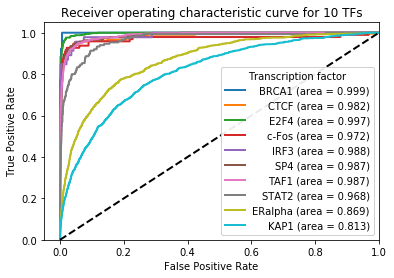

In [5]:
# plot final figure: ROC curves and legend with AUC
fig = plt.figure()
for i, TF in enumerate(TFsimple):
    plt.plot(fpr[i], tpr[i], lw=2, label=TF+' (area = %0.3f)' % auc[i])
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--') # random (AUC=0.5) model for comparison
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for 10 TFs')
ax = fig.get_axes()[0]
legend = ax.legend(loc="lower right", fontsize='medium', title='Transcription factor', framealpha=0.92)

# to align the legend text to the right
renderer = fig.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right')
    t.set_position((shift,0))
    
#plt.savefig('ROC_curve_10TFs_low.png')
plt.show()